# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
# recherche fichiers POIDS : format data_BEN_xxxxxx.zip

# Source : Withings https://healthmate.withings.com/

# Account > User > Parameters > Download ==> data_BEN_xxxxx.zip ==> contient weight.csv

pattern_poids = "^data_BEN_[\d]+[.]zip"
eng = re.compile(pattern_poids)
liste_zip_poids = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un data_BEN_dddd.zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_poids.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_poids) == 0:
    raise NameError(f'Aucun fichier de type data_BEN_xxxx.zip contenant \
        les données poids ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_poids)

idx = np.argmax(liste_mtime_zips)
filename_poids = liste_zip_poids[idx]

print(f"Le fichier poids le plus récent est : {filename_poids}, parmi :\n")
for f in liste_zip_poids:
    print(f"{f}")

Le fichier poids le plus récent est : data_BEN_1678611307.zip, parmi :

data_BEN_1678339764.zip
data_BEN_1677991606.zip
data_BEN_1678263371.zip
data_BEN_1678084168.zip
data_BEN_1677920167.zip
data_BEN_1678513276.zip
data_BEN_1678611307.zip
data_BEN_1678428348.zip
data_BEN_1678179170.zip
data_BEN_1677824810.zip
data_BEN_1677750157.zip


In [4]:
# recherche fichiers FOOD : format File-Export-YYYY-MM-DD-to-YYYY-MM-DD.zip

# https://www.myfitnesspal.com/reports

# www.myfitnesspal.com ==> reports > export data ==> File-Export-date1-to-date2.zip

pattern_food = "^File-Export-[\d]{4}-[\d]{2}-[\d]{2}-to-[\d]{4}-[\d]{2}-[\d]{2}.*[.]zip"
eng = re.compile(pattern_food)
liste_zip_food = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un File-Export-....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_food.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_food) == 0:
    raise NameError(f'Aucun fichier de type File-Export-xxxx.zip contenant \
        les données food ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_food)

idx = np.argmax(liste_mtime_zips)
filename_food = liste_zip_food[idx]

print(f"Le fichier food le plus récent est : {filename_food}, parmi \n")

for f in liste_zip_food:
    print(f"{f}")

Le fichier food le plus récent est : File-Export-2020-08-03-to-2023-03-12.zip, parmi 

File-Export-2020-08-03-to-2023-03-09.zip
File-Export-2020-08-03-to-2023-03-05.zip
File-Export-2020-08-03-to-2023-03-03.zip
File-Export-2020-08-03-to-2023-03-11.zip
File-Export-2020-08-03-to-2023-03-10.zip
File-Export-2020-08-03-to-2023-03-02.zip
File-Export-2020-08-03-to-2023-03-12.zip
File-Export-2020-08-03-to-2023-03-06.zip
File-Export-2020-08-03-to-2023-03-07.zip
File-Export-2020-08-03-to-2023-03-08.zip


In [5]:
# recherche fichiers EXO par POLAR : format polar-user-data-export.zip

# https://account.polar.com/#export ==> polar-user-data-export-xxxxx.zip

pattern_polar = "^polar-user-data-export_.+[.]zip"
eng = re.compile(pattern_polar)
liste_zip_polar = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un polar-user-data-export_....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_polar.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_polar) == 0:
    raise NameError(f'Aucun fichier de type polar-user-data-export_xxxx.zip contenant \
        les données exercices de Polar ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_polar)

idx = np.argmax(liste_mtime_zips)
filename_polar = liste_zip_polar[idx]

print(f"Le fichier exercices le plus récent est : {filename_polar}, parmi :\n")

for f in liste_zip_polar:
    print(f"{f}")

Le fichier exercices le plus récent est : polar-user-data-export_1718a8f4-bfb9-43c8-9086-7aef91e97caa.zip, parmi :

polar-user-data-export_1718a8f4-bfb9-43c8-9086-7aef91e97caa.zip
polar-user-data-export_27e6b481-f379-40fa-86d2-758b1c3cfa9b.zip


In [6]:
# copie les trois fichiers sélectionnés dans le répertoire de travail

import_pathname = '/home/benjamin/Folders_Python/Weight/imports/'

src = [filename_food,
       filename_poids,
       filename_polar]

dst = ['food', 'poids', 'polar']

for s,d in zip(src, dst):
       shutil.copy(downloads_rep + s, import_pathname + d)
       
print(f"Utilise : {filename_food}, {filename_poids}, {filename_polar}")

Utilise : File-Export-2020-08-03-to-2023-03-12.zip, data_BEN_1678611307.zip, polar-user-data-export_1718a8f4-bfb9-43c8-9086-7aef91e97caa.zip


In [7]:
# Récupère données POIDS

withings_filename = import_pathname + 'poids'  # fichier zip le plus récent de HealthMate Withings

with ZipFile(withings_filename, 'r') as weight_zip:
    weight_csv = weight_zip.extract('weight.csv', path=import_pathname)

# extrait la dataframe poids ----------------

colnames = ['Date', 'Poids (kg)', 'Gras (kg)', 'Masse osseuse (kg)', 'Masse musculaire (kg)', 'Hydratation (kg)']

df_weight = pd.read_csv(weight_csv, usecols=colnames)

os.remove(weight_csv)

df_weight.rename(columns = {'Poids (kg)' : 'Masse_Totale' , 
                            'Gras (kg)' : 'Masse_Grasse',
                            'Masse osseuse (kg)' : 'Masse_Osseuse',
                            'Masse musculaire (kg)' : 'Masse_Musculaire',
                            'Hydratation (kg)' : 'Masse_Hydrique'
                            }, 
                 inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d %H:%M:%S'

df_weight['Date'] = df_weight['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_weight = df_weight.groupby('Date').mean()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_weight = df_weight[df_weight.index >= start_date]

subset = ['Masse_Totale', 'Masse_Grasse']
df_weight.dropna(subset = subset, inplace=True)

# df_weight['Masse_Maigre'] = df_weight['Masse_Totale'] - df_weight['Masse_Grasse']
df_weight['MG%'] = df_weight['Masse_Grasse'] / df_weight['Masse_Totale']
df_weight['BMR'] = 370 + 21.6 * (df_weight['Masse_Totale'] - df_weight['Masse_Grasse'])

df_weight.sort_index(inplace=True)

In [8]:
# df_weight

In [9]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-02-26,72.360000,10.880000,NaN,NaN,NaN,0.150359,1697.968000
2023-02-27,72.750000,11.783333,NaN,NaN,NaN,0.161970,1686.880000
2023-02-28,72.725000,11.825000,NaN,NaN,NaN,0.162599,1685.440000
2023-03-01,71.992857,11.638571,NaN,NaN,NaN,0.161663,1673.652571
2023-03-02,71.725000,11.926667,NaN,NaN,NaN,0.166283,1661.644000
2023-03-03,71.285714,11.317143,NaN,NaN,NaN,0.158758,1665.321143
2023-03-04,70.656667,11.420000,2.961667,56.258333,39.496667,0.161627,1649.512000
2023-03-05,71.880000,11.848571,3.000000,57.014286,40.180000,0.164838,1666.678857
2023-03-06,71.030000,10.924000,3.010000,57.082000,40.476000,0.153794,1668.289600


In [10]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-02-26,71.347806,11.109184,NaN,NaN,NaN,0.155718,1671.154245
2023-02-27,71.523316,11.171497,NaN,NaN,NaN,0.156192,1673.599306
2023-02-28,71.756352,11.255068,NaN,NaN,NaN,0.156835,1676.827735
2023-03-01,71.888367,11.294328,NaN,NaN,NaN,0.157087,1678.831245
2023-03-02,71.958265,11.414260,NaN,NaN,NaN,0.158607,1677.750510
2023-03-03,72.031224,11.455816,NaN,NaN,NaN,0.159031,1678.428816
2023-03-04,71.927891,11.541531,NaN,NaN,NaN,0.160466,1674.345388
2023-03-05,71.859320,11.679898,NaN,NaN,NaN,0.162534,1669.875510
2023-03-06,71.613605,11.557136,NaN,NaN,NaN,0.161366,1667.219739


In [11]:
# Récupère données FOOD

mfp_filename = import_pathname + "food" # données de My Fitness Pal

# Extrait les archives
    
with ZipFile(mfp_filename, 'r') as food_zip:
    output_dir = food_zip.namelist()
    target = 'Nutrition-Summary'
    for l in output_dir:
        if l[:len(target)] == target:
            food_csv = food_zip.extract(l, path=import_pathname)
            break
        
# extrait la dataframe food -------------------------------

colnames = ['Date', 'Meal', 'Calories', 'Fat (g)', 'Carbohydrates (g)', 'Protein (g)']

df_food = pd.read_csv(food_csv, usecols=colnames)
os.remove(food_csv)

df_food.rename(columns = {'Fat (g)' : 'Lipides' , 'Carbohydrates (g)' : 'Glucides', 'Protein (g)' : 'Proteines'}, inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d'

df_food['Date'] = df_food['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_food = df_food.groupby('Date').sum()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_food = df_food[df_food.index >= start_date]
df_food.dropna(inplace=True)
df_food.sort_index(inplace=True)

/tmp/ipykernel_8548/2576819218.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_food = df_food.groupby('Date').sum()


In [12]:
# df_food.tail(15)

In [13]:
df_food.rolling(window=7).mean().tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-02-25,2045.228571,60.557143,209.442857,144.385714
2023-02-26,2050.942857,61.214286,205.200000,146.100000
2023-02-27,2031.585714,66.685714,194.328571,140.071429
2023-02-28,2027.200000,67.928571,194.971429,134.200000
2023-03-01,2021.214286,64.071429,193.228571,142.814286
2023-03-02,2017.085714,64.714286,190.957143,142.985714
2023-03-03,1953.171429,63.328571,180.814286,149.685714
2023-03-04,1866.071429,52.885714,178.142857,154.271429
2023-03-05,1831.071429,47.014286,186.671429,159.171429


In [14]:
def extract_data_training(exo_dict):
    # utility fonction pour récupérer : date, durée, type exercice et calories dépensées
    
    # récupère date
    pattern = '2(\d){3,3}-(\d){2,2}-(\d){2,2}'  # on cherche une date du type 2xxx-yy-zz
    p = re.compile(pattern)
    m = p.search(exo_dict.get('startTime'))
    if m: 
        time_format = '%Y-%m-%d'
        exo_date = datetime.datetime.strptime( exo_dict.get('startTime')[:10], time_format ).date()
    
    # récupère durée
    pattern = '(\d)+[.]?(\d)*'  # on cherche une durée du type xxxx.yyyy
    p = re.compile(pattern)
    m = p.search(exo_dict.get('duration'))
    if m:
        exo_duration = float(m.group())
    
    # récupère type activité et calories dépensées
    d = exo_dict.get('exercises')[0]   
    exo_type = d.get('sport')
    if d.get('kiloCalories'):
        exo_cals = float(d.get('kiloCalories'))
    else:
        exo_cals = 0.0
    
    return exo_date, exo_duration, exo_type, exo_cals

In [15]:
# Récupère les données EXERCICE

polar_filename = import_pathname + "polar"  # données de Polar

with ZipFile(polar_filename, 'r') as polar_zip:
    output_dir = polar_zip.namelist()
    
    target = 'training-session'
    dict_all_exos = {}
    for i, enr_name in enumerate(tqdm(output_dir)): # on parcourt la liste des archives
        if enr_name[:len(target)] == target:  # si c'est un enregistrement d'une session de training, on traite
            enr_json = polar_zip.extract(enr_name, path=import_pathname)   # extraction du json
            with open(enr_json, 'r') as f:
                exo_dict = json.load(f)
                exo_date, exo_duration, exo_type, exo_cals = extract_data_training(exo_dict)
                if dict_all_exos.get(exo_date) == None:
                    dict_all_exos[exo_date] = [ exo_duration, exo_cals]
                else:
                    dict_all_exos[exo_date] = [ dict_all_exos[exo_date][0] + exo_duration, dict_all_exos[exo_date][1] + exo_cals ]
                # print(f'exercice {i+1} : date = {exo_date}, durée = {exo_duration}, type = {exo_type}, cals = {exo_cals}')
            os.remove(enr_json)
    
    df_exos = pd.DataFrame.from_dict(dict_all_exos, orient='index', columns=['exo_duree', 'exo_cals_bruts']).sort_index()

100%|██████████| 724/724 [00:09<00:00, 77.12it/s]


In [16]:
df_exos.tail(15)

,exo_duree,exo_cals_bruts
2023-02-13,5734.301,575.0
2023-02-14,2684.711,327.0
2023-02-15,2165.337,358.0
2023-02-16,5184.837,550.0
2023-02-17,2591.106,291.0
2023-02-18,5400.856,679.0
2023-02-20,6291.610,691.0
2023-02-22,3180.720,471.0
2023-02-23,5295.303,572.0
2023-02-25,3000.728,445.0


In [17]:
# Ajout à la main des exos depuis le xx Janvier inclus pour palier à la fréquence de rafraîchissement de l'extraction Polar

# récupère fichier brut .csv
exos_persos_filename = "/home/benjamin/Folders_Python/Weight/imports/Exos_Persos.csv"
df_exos_persos = pd.read_csv(exos_persos_filename)

# convertit la colonne Jour en datetime objects en colonne Date
pattern_date = '[\d]{2}/[\d]{2}/[\d]{2}'
p = re.compile(pattern_date)

day_format = "%d/%m/%y"

df_exos_persos['Date'] = df_exos_persos['Jour'].apply( lambda x : datetime.datetime.strptime(p.search(x).group(0), day_format).date() )

# drope la colonne Jour, somme tous les exercices par date
df_exos_persos.drop(columns=['Jour'], inplace=True)

df_exos_persos = df_exos_persos.groupby('Date').sum()

# met au bon format la duree de l'exercice (minutes => secondes)
df_exos_persos['exo_duree'] = df_exos_persos['Duree'] * 60
df_exos_persos.drop(columns=['Duree'], inplace=True)

In [18]:
df_exos_persos

,exo_cals_bruts,exo_duree
Date,,
2023-03-04,0,0
2023-03-05,443,4620
2023-03-06,614,6000
2023-03-07,1223,12420
2023-03-08,410,3720
2023-03-09,870,8100
2023-03-10,90,1200
2023-03-11,570,5040


In [19]:
# enfin, concatène avec le fichier issu de Polar
df_exos_total = pd.concat( [df_exos, df_exos_persos], axis=0 ).sort_index()

In [20]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
2023-02-23,5295.303,572.0
2023-02-25,3000.728,445.0
2023-02-27,2220.712,358.0
2023-02-28,4828.828,516.0
2023-03-01,1560.712,230.0
2023-03-02,4707.962,512.0
2023-03-03,1841.087,222.0
2023-03-04,0.000,0.0
2023-03-05,4620.000,443.0
2023-03-06,6000.000,614.0


In [21]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
2023-02-23,4301.395571,516.000000
2023-02-25,4420.737143,528.428571
2023-02-27,3997.290714,501.000000
2023-02-28,4316.965286,533.142857
2023-03-01,3768.373286,469.000000
2023-03-02,3542.137857,443.428571
2023-03-03,3350.761714,407.857143
2023-03-04,2594.289857,326.142857
2023-03-05,2825.614429,325.857143
2023-03-06,3365.512714,362.428571


In [22]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [23]:
# df_all

In [24]:
# df_all.rolling(window=7).mean().tail(15)

In [25]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [26]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [27]:
# df_all.head(20)
# df_all.describe(include='all')
# df_all.info()

In [28]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-02-25,71.380000,10.820000,NaN,NaN,NaN,0.151583,1678.096000,2880.8,123.3,231.0,162.0,3000.728,445.0,386.718638,2064.814638,815.985362
2023-02-26,72.360000,10.880000,NaN,NaN,NaN,0.150359,1697.968000,2019.3,68.8,165.4,119.4,0.000,0.0,0.000000,1697.968000,321.332000
2023-02-27,72.750000,11.783333,NaN,NaN,NaN,0.161970,1686.880000,1718.4,72.3,128.4,137.9,2220.712,358.0,314.642654,2001.522654,-283.122654
2023-02-28,72.725000,11.825000,NaN,NaN,NaN,0.162599,1685.440000,1774.5,32.3,245.2,126.1,4828.828,516.0,421.802085,2107.242085,-332.742085
2023-03-01,71.992857,11.638571,NaN,NaN,NaN,0.161663,1673.652571,1750.1,31.8,203.6,163.6,1560.712,230.0,199.767481,1873.420052,-123.320052
2023-03-02,71.725000,11.926667,NaN,NaN,NaN,0.166283,1661.644000,1746.5,61.7,125.1,178.0,4707.962,512.0,421.456518,2083.100518,-336.600518
2023-03-03,71.285714,11.317143,NaN,NaN,NaN,0.158758,1665.321143,1782.6,53.1,167.0,160.8,1841.087,222.0,186.513876,1851.835019,-69.235019
2023-03-04,70.656667,11.420000,2.961667,56.258333,39.496667,0.161627,1649.512000,2271.1,50.2,212.3,194.1,0.000,0.0,0.000000,1649.512000,621.588000
2023-03-05,71.880000,11.848571,3.000000,57.014286,40.180000,0.164838,1666.678857,1774.3,27.7,225.1,153.7,4620.000,443.0,353.878978,2020.557835,-246.257835
2023-03-06,71.030000,10.924000,3.010000,57.082000,40.476000,0.153794,1668.289600,1759.7,40.3,203.3,146.5,6000.000,614.0,498.146556,2166.436156,-406.736156


In [29]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-02-25,71.213044,11.128946,NaN,NaN,NaN,0.156279,1667.816531,2045.228571,60.557143,209.442857,144.385714,2538.337286,311.285714,262.246698,1930.063228,115.165343
2023-02-26,71.347806,11.109184,NaN,NaN,NaN,0.155718,1671.154245,2050.942857,61.214286,205.200000,146.100000,2538.337286,311.285714,262.246698,1933.400943,117.541915
2023-02-27,71.523316,11.171497,NaN,NaN,NaN,0.156192,1673.599306,2031.585714,66.685714,194.328571,140.071429,1956.780429,263.714286,225.851580,1899.450886,132.134828
2023-02-28,71.756352,11.255068,NaN,NaN,NaN,0.156835,1676.827735,2027.200000,67.928571,194.971429,134.200000,2646.613000,337.428571,286.109021,1962.936755,64.263245
2023-03-01,71.888367,11.294328,NaN,NaN,NaN,0.157087,1678.831245,2021.214286,64.071429,193.228571,142.814286,2415.183286,303.000000,256.089712,1934.920957,86.293329
2023-03-02,71.958265,11.414260,NaN,NaN,NaN,0.158607,1677.750510,2017.085714,64.714286,190.957143,142.985714,2331.277429,294.428571,249.198197,1926.948707,90.137007
2023-03-03,72.031224,11.455816,NaN,NaN,NaN,0.159031,1678.428816,1953.171429,63.328571,180.814286,149.685714,2594.289857,326.142857,275.843036,1954.271852,-1.100424
2023-03-04,71.927891,11.541531,NaN,NaN,NaN,0.160466,1674.345388,1866.071429,52.885714,178.142857,154.271429,2165.614429,262.571429,220.597516,1894.942904,-28.871476
2023-03-05,71.859320,11.679898,NaN,NaN,NaN,0.162534,1669.875510,1831.071429,47.014286,186.671429,159.171429,2825.614429,325.857143,271.151656,1941.027166,-109.955738
2023-03-06,71.613605,11.557136,NaN,NaN,NaN,0.161366,1667.219739,1836.971429,42.442857,197.371429,160.400000,3365.512714,362.428571,297.366499,1964.586238,-127.614809


# Graphes

In [30]:
vars = ['MG%', 'Calories', 'cal_deficit'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

dict_hlines = {
        'Calories' : [ (1700, 'green'), (1800, 'orange'), (2000, 'red') ],
        'cal_deficit' : [ (-300, 'green'), (-100, 'orange'), (200, 'red' )]
    }

In [31]:
def plot_general(longueur=15,
                 year=2023,
                 month=1,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col)
        
    plt.plot()

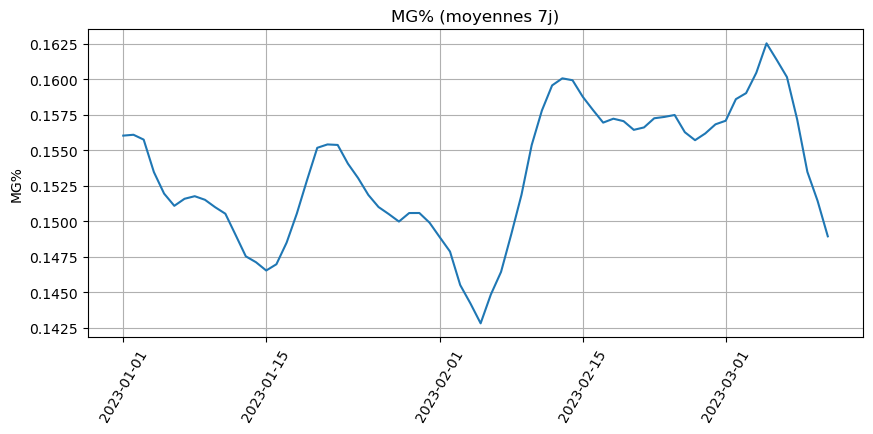

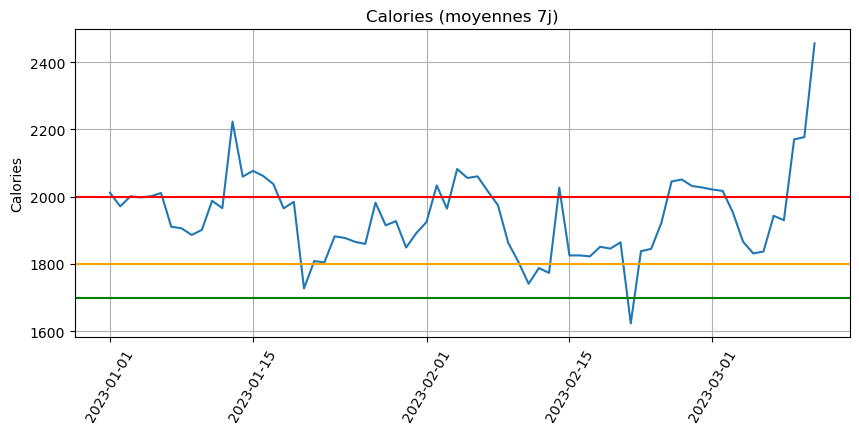

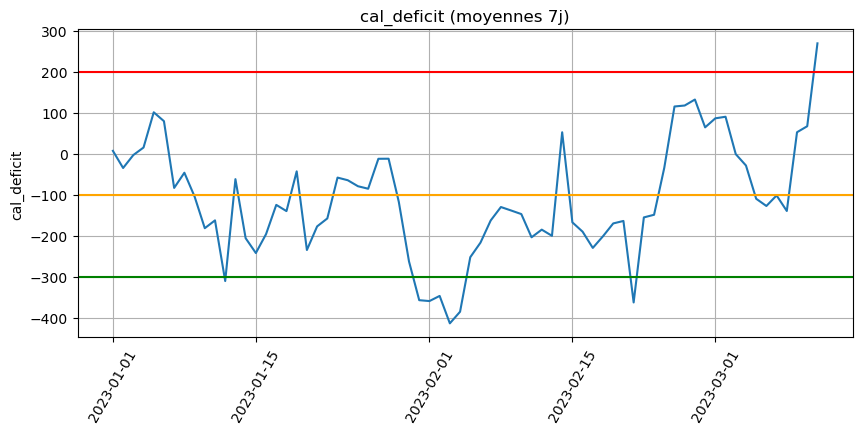

In [32]:
plot_general(longueur=7)

In [33]:
ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general(longueur=15, year=2023, month=1, day=1)>

In [35]:
def plot_general2(longueur=15,
                 year=2022,
                 month=11,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='x', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.11, top=0.16)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='o', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-500.0, top=300.0)
    # ax2.legend()

In [36]:
ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2022…

<function __main__.plot_general2(longueur=15, year=2022, month=11, day=1)>

In [37]:
def plot_general3(longueur=15,
                 year=2022,
                 month=11,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='x', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.11, top=0.16)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='o', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1700.0, top=2500.0)
    # ax2.legend()

In [38]:
ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2022…

<function __main__.plot_general3(longueur=15, year=2022, month=11, day=1)>